## 1. 训练

## 1.1 基于默认预训练模型训练

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
pretrained_model_dir = 'pretrain_models'
os.makedirs(pretrained_model_dir, exist_ok=True)
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join(pretrained_model_dir, 'best_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                pretrained_model_path = os.path.join(pretrained_model_dir, f'resnet_epoch_{epoch}.pt')
                torch.save(model.state_dict(), pretrained_model_path)
#                 torch.save(model.state_dict(), best_model_params_path)


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model

In [5]:
# model_ft = models.resnet18()
# 定义本地预训练模型的路径
model_path = 'resnet50.pth'

# 实例化一个 ResNet-50 模型
model_ft = models.resnet50()

# 加载本地预训练模型的权重
checkpoint = torch.load(model_path)
model_ft.load_state_dict(checkpoint)


num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("model loaded")

model loaded


In [6]:
model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.6109 Acc: 0.6803
val Loss: 0.1615 Acc: 0.9412
Epoch 1/1
----------
train Loss: 0.3102 Acc: 0.8689
val Loss: 0.5818 Acc: 0.8039
Training complete in 0m 39s
Best val Acc: 0.941176


In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        print("AAA", preds[0])
        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)
        print(class_names[preds[0]])

AAA tensor(0, device='cuda:0')


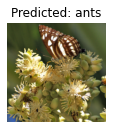

ants


In [13]:
a = visualize_model_predictions(
    model,
    img_path='dataset/val/bees/72100438_73de9f17af.jpg'
)


plt.ioff()
plt.show()

In [21]:
# 加载模型
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("pretrain_models/resnet_epoch_1.pth"))
model = model.to(device)
model.eval()
print('Model loaded')

# 加载图像
image_path = 'dataset/val/bees/72100438_73de9f17af.jpg'  # 这里替换为你的图片路径
image = Image.open(image_path)

# 应用相同的数据预处理
image = data_transforms['val'](image).unsqueeze(0).to(device)

# 预测
outputs = model(image)
_, preds = torch.max(outputs, 1)
print(f'The predicted class is: {class_names[preds.item()]}')


Model loaded
The predicted class is: bees
